# Intro
In this notebook I am going to explore the data a little bit.
The competition goal is to give probability estimation to if an image contains a cat or a dog.
The content score is measured by by LogLoss, where
* y=1 -> dog
* y=0 -> cat

We will try to minimize the score
      

# Preprocess the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm      # a nice pretty percentage bar for tasks.
from random import shuffle

 Creating lists of image file names for both cats and dogs

In [2]:
TRAIN_DIR = '../input/train/' 
TEST_DIR = '../input/test/'

image_list = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] 
dog_image_list = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
cat_image_list = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_image_list = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

shuffle(dog_image_list)
shuffle(cat_image_list)

In [3]:
print('Total images:\t',len(image_list),
      '\nDog Images:\t',len(dog_image_list),
      '\nCat Images:\t',len(cat_image_list),
      '\nTestImages:\t',len(test_image_list))

Total images:	 25000 
Dog Images:	 12500 
Cat Images:	 12500 
TestImages:	 12500


We can see that there is equal number of images to cats and dogs

Now we are going to load the images and resize them to 64x64x3

In [4]:
ROWS = 64
COLS = 64
CHANNELS = 3

def load_image(file_path, size=(ROWS,COLS)):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    return cv2.resize(rgb_img, (ROWS,COLS))
    

def load_image_list(file_list, ret_labels=True, num_of_img=12500):
#     count = len(file_list)
    data = np.ndarray((num_of_img, ROWS, COLS, CHANNELS), dtype=np.uint8)
    labels = []
    
    for i, image_name in tqdm(enumerate(file_list)):
        if i >= num_of_img:
            break
        data[i] = load_image(image_name)
        if ret_labels:
            if 'dog' in image_name:
                labels.append(1)
            else:
                labels.append(0)
    return data, labels

def matrix_divide_by_chunks(matrix, chunk_size):
    for i in range(chunk_size):
        matrix[(chunk_size*i):(chunk_size*(i+1))] = matrix[(chunk_size*i):(chunk_size*(i+1))] / 255.0
#     org_flat_mat = matrix.flatten()
#     final_matrix = np.zeros(shape=org_flat_mat.shape)
    
#     for i in range(chunk_size):
#         final_matrix = org_flat_mat[i*chunk_size:(i+1)*chunk_size] / 255.0
    
#     return final_matrix.reshape(matrix.shape)
        
    

In [5]:
IMG_NUM = 12500

print("Loading Dogs' Images...")
dog_data_images, dog_data_labels = load_image_list(dog_image_list, num_of_img=IMG_NUM)
dog_train_images, dog_val_images, dog_train_labels, dog_val_labels = train_test_split(dog_data_images, dog_data_labels,
                                                    test_size=0.2, random_state=2)


print("Loading Cats' Images...")
cat_data_images, cat_data_labels = load_image_list(cat_image_list, num_of_img=IMG_NUM)
cat_train_images, cat_val_images, cat_train_labels, cat_val_labels = train_test_split(cat_data_images, cat_data_labels,
                                                   test_size=0.2, random_state=2)

train_data = np.concatenate((dog_train_images, cat_train_images), axis=0)
train_labels = dog_train_labels + cat_train_labels
# train_labels = to_categorical(train_labels, num_classes=2)

val_data = np.concatenate((dog_val_images, cat_val_images), axis=0)
val_labels = dog_val_labels + cat_val_labels
# val_labels = to_categorical(val_labels, num_classes=2)

Loading Dogs' Images...


12500it [00:40, 310.28it/s]


Loading Cats' Images...


12500it [00:38, 325.40it/s]


In [6]:
# Normalize the data
# matrix_divide_by_chunks(train_data, 1000)
# matrix_divide_by_chunks(val_data, 1000)
# train_data = np.true_divide(train_data,1000)
train_data = train_data / 255.0
val_data = val_data / 255.0

print ("Training data shape: {}".format(train_data.shape))
print ("Labels length: {}".format(len(train_labels)))

Training data shape: (20000, 64, 64, 3)
Labels length: 20000


## Lets show some images
sum dogs images

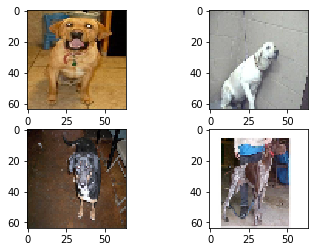

In [7]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(train_data[0])
axarr[0,1].imshow(train_data[1])
axarr[1,0].imshow(train_data[2])
axarr[1,1].imshow(train_data[3])

Some cats Images

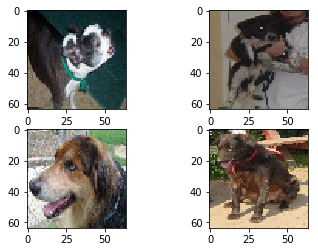

In [8]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(train_data[1000])
axarr[0,1].imshow(train_data[1001])
axarr[1,0].imshow(train_data[1002])
axarr[1,1].imshow(train_data[1003])
plt.show()

We will generate more data to prevent the model from overffiting

In [9]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(train_data)


# Building simple classifier

We are going to build a deep network for this task using keras and tensorflow.

In [12]:
regl2 = regularizers.l2(0.01)

model = Sequential()

# BLOC 1
model.add(Conv2D(filters=32, kernel_size=(4,4), padding='Same', activation='relu', input_shape=(ROWS,COLS,CHANNELS)))
model.add(Conv2D(filters=32, kernel_size=(4,4), padding='Same', activation='relu'))
# model.add(Conv2D(filters=32, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))

# BLOC 2
model.add(Conv2D(filters=64, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(4,4), padding='Same', activation='relu'))
# model.add(Conv2D(filters=64, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))

# BLOC 3
model.add(Conv2D(filters=128, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))

# BLOC 4 size of 16x16
model.add(Flatten())
# model.add(Dense(1024, activation='relu', kernel_regularizer=regl2))
model.add(Dense(16*16, activation='relu'))
model.add(Dense(16*16, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # check if we could use softmax function instead
optimizer = SGD(lr=0.03)
#optimizer = Adam()


epochs = 80

batch_size = 150

model.compile(optimizer=optimizer, loss="binary_crossentropy",
              metrics=["accuracy"])


In [13]:
# Save the checkpoint in the /output folder
filepath = "cat_dog_best_reg3_v3"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')



history = model.fit_generator(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    steps_per_epoch=len(train_data) / batch_size, epochs=epochs, verbose=2, 
                    validation_data=(val_data, val_labels),
                   callbacks=[checkpoint])


# history = model.fit(x=train_data, y=train_labels, batch_size=batch_size,
#                     epochs=epochs, verbose=2, validation_data=(val_data, val_labels),
#                    callbacks=[checkpoint])

Epoch 1/80

Epoch 00001: val_loss improved from inf to 0.69213, saving model to cat_dog_best_reg3_v3
 - 30s - loss: 0.6917 - acc: 0.5239 - val_loss: 0.6921 - val_acc: 0.5358
Epoch 2/80

Epoch 00002: val_loss improved from 0.69213 to 0.69165, saving model to cat_dog_best_reg3_v3
 - 25s - loss: 0.6865 - acc: 0.5519 - val_loss: 0.6916 - val_acc: 0.5000
Epoch 3/80

Epoch 00003: val_loss did not improve from 0.69165
 - 26s - loss: 0.6751 - acc: 0.5814 - val_loss: 0.6948 - val_acc: 0.5002
Epoch 4/80

Epoch 00004: val_loss did not improve from 0.69165
 - 26s - loss: 0.6598 - acc: 0.6091 - val_loss: 0.6940 - val_acc: 0.5036
Epoch 5/80

Epoch 00005: val_loss improved from 0.69165 to 0.69075, saving model to cat_dog_best_reg3_v3
 - 26s - loss: 0.6504 - acc: 0.6222 - val_loss: 0.6907 - val_acc: 0.5134
Epoch 6/80

Epoch 00006: val_loss improved from 0.69075 to 0.68391, saving model to cat_dog_best_reg3_v3
 - 25s - loss: 0.6423 - acc: 0.6370 - val_loss: 0.6839 - val_acc: 0.5752
Epoch 7/80

Epoch 00

Epoch 59/80

Epoch 00059: val_loss did not improve from 0.68190
 - 26s - loss: 0.4236 - acc: 0.8019 - val_loss: 0.8717 - val_acc: 0.5096
Epoch 60/80

Epoch 00060: val_loss did not improve from 0.68190
 - 27s - loss: 0.4177 - acc: 0.8082 - val_loss: 0.9517 - val_acc: 0.5118
Epoch 61/80

Epoch 00061: val_loss did not improve from 0.68190
 - 26s - loss: 0.4097 - acc: 0.8121 - val_loss: 0.9733 - val_acc: 0.5100
Epoch 62/80

Epoch 00062: val_loss did not improve from 0.68190
 - 25s - loss: 0.4134 - acc: 0.8094 - val_loss: 0.8623 - val_acc: 0.5164
Epoch 63/80

Epoch 00063: val_loss did not improve from 0.68190
 - 25s - loss: 0.4063 - acc: 0.8110 - val_loss: 0.9805 - val_acc: 0.5022
Epoch 64/80

Epoch 00064: val_loss did not improve from 0.68190
 - 25s - loss: 0.4099 - acc: 0.8122 - val_loss: 0.9727 - val_acc: 0.5068
Epoch 65/80

Epoch 00065: val_loss did not improve from 0.68190
 - 25s - loss: 0.4033 - acc: 0.8145 - val_loss: 0.9174 - val_acc: 0.5138
Epoch 66/80

Epoch 00066: val_loss did no

# Visualize the accuracy gain
Let's plot the run history, and see if the model converge. In the first run we reached loss of 0.4122, we can do better.

In [ ]:
fig, ax = plt.subplots(2,1)
# Loss Plot
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')

legend = ax[0].legend(loc='best', shadow=True)

# Accuracy Plot
ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)

# Fitting the test data

In [ ]:
print("Loading Test Images...")
test_data, _ = load_image_list(test_image_list, False)
test_data = test_data / 255.0

print ("Test data shape: {}".format(test_data.shape))

In [ ]:
test_predictions = model.predict(test_data, verbose=1)

In [ ]:
print ("Test prediction shape: {}".format(test_predictions.shape))
with open('submission_file.csv','w') as f:
    f.write('id,label\n')

print("Saving the prediction results...")
with open('submission_file.csv','a') as f:
    for i, prediction in tqdm(enumerate(test_predictions)):
        f.write('{},{}\n'.format(i+1,prediction[0]))